## EDA5 - Feature Reduction Analysis Using LightGBM
#### 1. [Installation and Importing of Libraries](#eda_import)
#### 2. [Data Retrieval](#eda_csv)
#### 3. [Base Model](#eda_base)
#### 4. [Imbalanced Parameter](#eda_imb)
#### 5. [PCA on BMD](#eda_pca)
#### 6. [Remove Correlated Variables](#eda_corr)
#### 7. [Boruta Technique](#eda_bor)
#### 8. [SMOTE Resampling](#eda_SMOTE)

### <a name="eda_import"></a>Installation and Importing of Libraries

In [65]:
!pip install seaborn --upgrade

Requirement already up-to-date: seaborn in /opt/conda/lib/python3.7/site-packages (0.12.2)


In [66]:
!pip install lightgbm==3.3.5

In [67]:
!pip install --upgrade scikit-learn

Requirement already up-to-date: scikit-learn in /opt/conda/lib/python3.7/site-packages (1.0.2)


In [68]:
!pip install boruta

In [69]:
!pip install imblearn

In [70]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import mpl_toolkits.mplot3d
from boruta import BorutaPy
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, average_precision_score,\
classification_report, auc, recall_score, roc_curve, precision_score, precision_recall_curve, roc_auc_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import lightgbm as lgb
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import warnings

In [71]:
warnings.filterwarnings('ignore')

In [72]:
def thresholdRecallPrecisionTable(y_test, y_pred_proc):
    precision,recall,thresholds = precision_recall_curve(y_test, y_pred_proc)
           
    table = {"Threshold":thresholds,"recall":recall[:-1],"precision":precision[:-1]}
    pd.set_option('display.max_rows', None)
    print(pd.DataFrame(table))
    pd.reset_option('all')   

In [73]:
def optimizedf1(y_test, y_pred_proc):
    precision,recall,thresholds = precision_recall_curve(y_test, y_pred_proc,pos_label=1)
    
    fscore = np.nan_to_num((2 * precision * recall) / (precision + recall))
    
    index = np.argmax(fscore)
    
    return thresholds[index]

In [74]:
def makeConfusionMatrixandScore(model,y_actual,X_set,thresh=0.5):
    ###A function for printing out a confusion matric and classification report
    ###to consistantly evaluate model performance
    y_pred_prob = model.predict(X_set)
    y_pred = pd.Series(y_pred_prob).apply(lambda x: 1 if x > thresh else 0)
    
    cm = confusion_matrix(y_actual,np.round(y_pred))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()    
    
    print(classification_report(y_actual, y_pred))
    
                                 

In [75]:
def plot_roc_and_prc(y_test, y_pred_proc):
    fpr,tpr,_ = roc_curve(y_test, y_pred_proc)
    precision,recall,thresholds = precision_recall_curve(y_test, y_pred_proc)
    
    
    auc = roc_auc_score(y_test, y_pred_proc)
    
    ap = average_precision_score(y_test, y_pred_proc)
    
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,8))
    
    
    ##plot ROC
    ax1.plot(fpr,tpr)
    ax1.plot([0,1],[0,1], "k-", color = "r",lw=1)
    ax1.annotate(f"AUC: {auc:.2f}",(.75,.25),weight="bold",size=14)
    ax1.set_ylabel('True Positive Rate/ Recall')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_title("ROC Curve")
    
    ##plot Precision-Recall Curve
    ax2.plot(recall,precision)
    ax2.set_ylabel("Precision")
    ax2.set_xlabel("Recall")
    ax2.set_title("Precision-Recall Curve")
    ax2.annotate(f"AP: {ap:.2f}",(.5,.75),weight="bold",size=14)
    
    plt.show()

### <a name= "eda_csv"> </a>  Get Training and Validation Data

In [76]:
X_train = pd.read_csv("/dsa/groups/casestudy2023su/team03/merged_data/X_train.csv")
y_train = pd.read_csv("/dsa/groups/casestudy2023su/team03/merged_data/y_train.csv")["FAFXNT_BIN"]
X_validation = pd.read_csv("/dsa/groups/casestudy2023su/team03/merged_data/X_validation.csv")
y_validation = pd.read_csv("/dsa/groups/casestudy2023su/team03/merged_data/y_validation.csv")["FAFXNT_BIN"]

In [77]:
y_train.shape

(4795,)

### <a name= "eda_base"></a> Light GBM Base Model
First we will test an out of the box Light GBM model on the data.

In [78]:

train_data = lgb.Dataset(X_train,label=y_train)

param = dict()
param["metric"] = "auc"
param["objective"] = 'binary'


bst = lgb.train(param, train_data)

[LightGBM] [Info] Number of positive: 1031, number of negative: 3764
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19745
[LightGBM] [Info] Number of data points in the train set: 4795, number of used features: 388
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215016 -> initscore=-1.294953
[LightGBM] [Info] Start training from score -1.294953


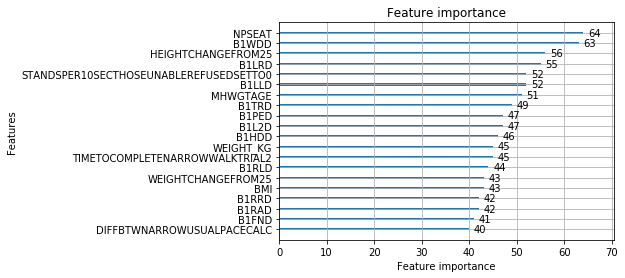

In [79]:
lgb.plot_importance(bst, max_num_features=20)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


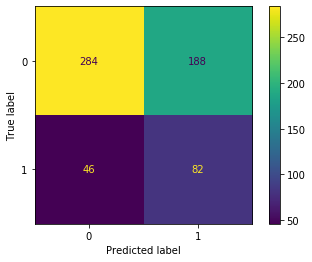

              precision    recall  f1-score   support

           0       0.86      0.60      0.71       472
           1       0.30      0.64      0.41       128

    accuracy                           0.61       600
   macro avg       0.58      0.62      0.56       600
weighted avg       0.74      0.61      0.65       600



In [80]:
thresh = optimizedf1(y_validation,bst.predict(X_validation))
makeConfusionMatrixandScore(bst,y_validation,X_validation, thresh = thresh)

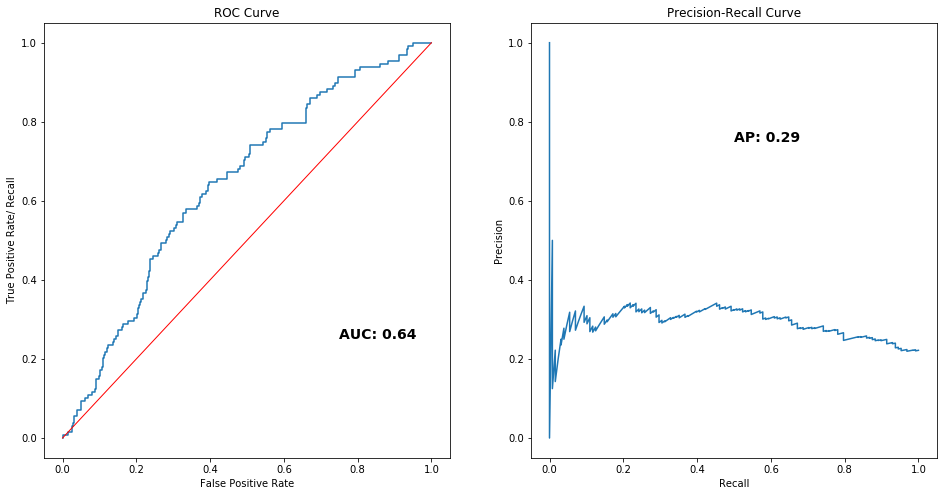

In [81]:
plot_roc_and_prc(y_validation,bst.predict(X_validation))

### <a name="eda_imb"> </a> Add imbalanced parameter
To account for the imbalanced nature of the data we will add a parameter.

In [83]:

train_data = lgb.Dataset(X_train,label=y_train)

param = dict()
param["metric"] = 'auc'
param["objective"] = 'binary'
##for imbalanced data
param["scale_pos_weight"] = 2.33



bst = lgb.train(param, train_data)

[LightGBM] [Info] Number of positive: 1031, number of negative: 3764
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19745
[LightGBM] [Info] Number of data points in the train set: 4795, number of used features: 388
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215016 -> initscore=-1.294953
[LightGBM] [Info] Start training from score -1.294953


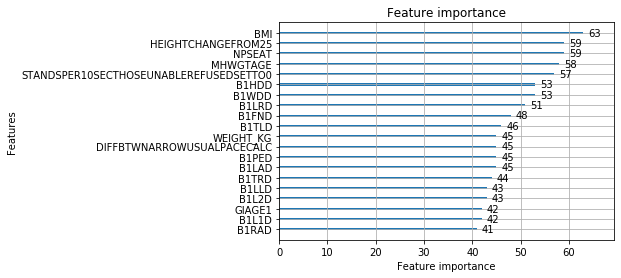

In [84]:
lgb.plot_importance(bst, max_num_features=20)

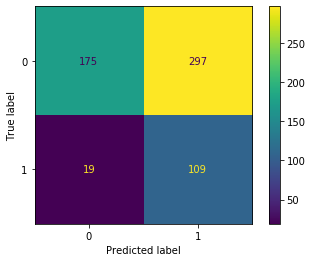

              precision    recall  f1-score   support

           0       0.90      0.37      0.53       472
           1       0.27      0.85      0.41       128

    accuracy                           0.47       600
   macro avg       0.59      0.61      0.47       600
weighted avg       0.77      0.47      0.50       600



In [85]:
thresh = optimizedf1(y_validation,bst.predict(X_validation))
makeConfusionMatrixandScore(bst,y_validation,X_validation, thresh = thresh)

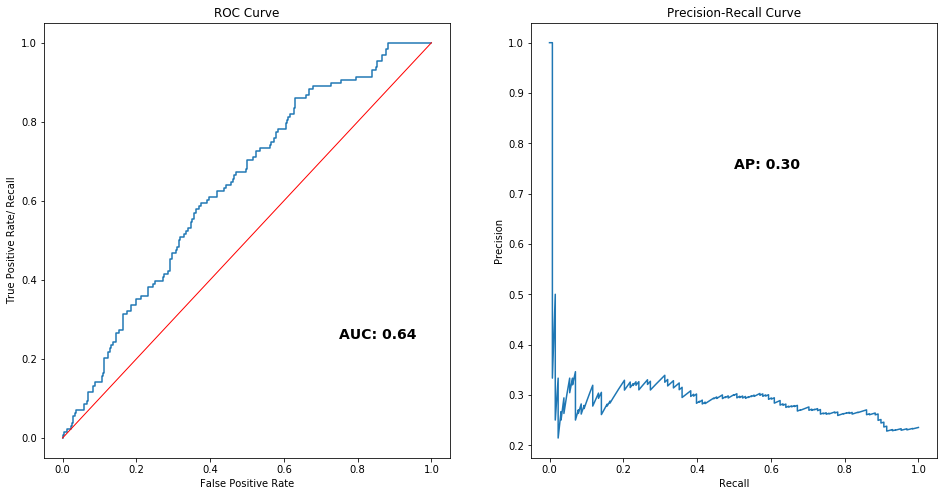

In [86]:
plot_roc_and_prc(y_validation,bst.predict(X_validation))

### <a name="eda_pca"></a>Incorporate PCA to reduce BMD.
In previous analysis PCA was performed on the BMD data. Because of the high dimensionality of the data this will be a good way to reduce some dimensions. PCA was shown to account for > 60% of the variance in one parameter with near immediate diminishing returns. Thus, we will use one EDA parameter.

In [88]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [89]:
pca = PCA(n_components=1)
scale = StandardScaler()

In [90]:
BMD_train = X_train.filter(regex=r"B1.+D")

In [91]:
BMD_validation = X_validation.filter(regex=r"B1.+D")

In [92]:
BMD_train_scale = scale.fit_transform(BMD_train)
BMD_pca = pca.fit_transform(BMD_train_scale)

In [93]:
BMD_pca

array([[ 4.86606804],
       [ 0.20204603],
       [ 2.37524942],
       ...,
       [ 0.65617334],
       [-5.82173255],
       [ 5.48798862]])

In [94]:
BMD_pca = pd.DataFrame(BMD_pca)
BMD_pca.columns = ["BMD_pca"]


In [95]:
BMD_Val_scale = scale.transform(BMD_validation)
BMD_Val_pca = pca.transform(BMD_Val_scale)
BMD_Val_pca = pd.DataFrame(BMD_Val_pca)
BMD_Val_pca.columns = ["BMD_pca"]


In [96]:
X_train = X_train.drop(BMD_train.columns,axis=1)
X_validation = X_validation.drop(BMD_validation.columns, axis=1)
X_train = pd.concat([X_train,BMD_pca],axis=1)
X_validation = pd.concat([X_validation,BMD_Val_pca],axis=1)

In [97]:

train_data = lgb.Dataset(X_train,label=y_train)

param = dict()
param["metric"] = 'auc'
param["objective"] = 'binary'
##for imbalanced data
param["scale_pos_weight"] = 2.33



bst = lgb.train(param, train_data)

[LightGBM] [Info] Number of positive: 1031, number of negative: 3764
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14390
[LightGBM] [Info] Number of data points in the train set: 4795, number of used features: 367
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215016 -> initscore=-1.294953
[LightGBM] [Info] Start training from score -1.294953


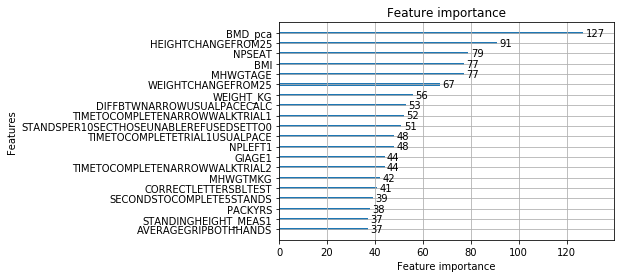

In [98]:
lgb.plot_importance(bst, max_num_features=20)

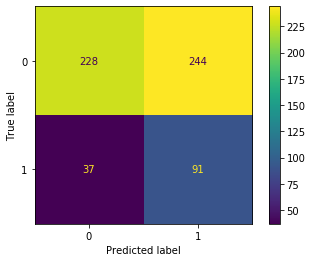

              precision    recall  f1-score   support

           0       0.86      0.48      0.62       472
           1       0.27      0.71      0.39       128

    accuracy                           0.53       600
   macro avg       0.57      0.60      0.51       600
weighted avg       0.73      0.53      0.57       600



In [99]:
thresh = optimizedf1(y_validation,bst.predict(X_validation))
makeConfusionMatrixandScore(bst,y_validation,X_validation, thresh = thresh)

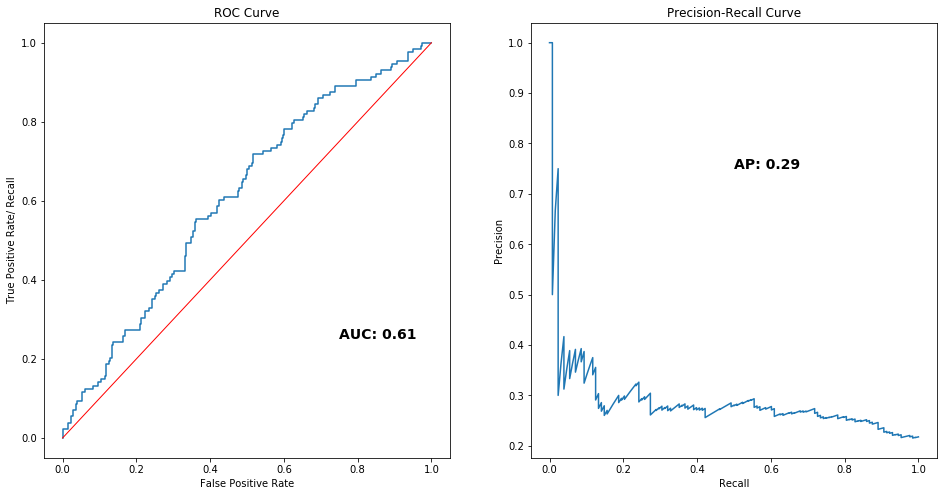

In [100]:
plot_roc_and_prc(y_validation,bst.predict(X_validation))

### <a name = "eda_corr"></a>Remove correlated variables
Another attempt to reduce dimensionality will be to reduce correlated pairs variables because they are sharing no new information.

In [102]:
# Calculate correlation matrix
correlation_matrix = X_train.corr().abs()

# It's really challening to visualize this since there are so many features
#plt.figure(figsize=(10, 8))
#sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
#plt.show()

# Instead, we'll list the specific feature without the visual
threshold = 0.85
high_corr_features = np.where(correlation_matrix > threshold)
high_corr_pairs = [(X_train.columns[x], X_train.columns[y], correlation_matrix.iloc[x, y]) for x, y in zip(*high_corr_features) if x != y]

for pair in high_corr_pairs:
    print(pair)

('NPHIPREP', 'NPHIPSD', 0.9546800826233092)
('NPHIPSD', 'NPHIPREP', 0.9546800826233092)
('NPSEAT', 'NPLEFTNO', 0.8714209361446218)
('NPSEAT', 'NPRGTNO', 0.8677695007218178)
('NPSEAT', 'NPREASL', 0.8765328503561449)
('NPSEAT', 'NPREASR', 0.8684483226588594)
('NPSEAT', 'NPREASB', 0.9011567849901043)
('NPLFST', 'NPSEATLT', 0.9973617385534578)
('NPSEATLT', 'NPLFST', 0.9973617385534578)
('NPLEFTNO', 'NPSEAT', 0.8714209361446218)
('NPLEFTNO', 'NPRGTNO', 0.9222626903140254)
('NPLEFTNO', 'NPREASL', 0.9310786215431177)
('NPLEFTNO', 'NPREASR', 0.8681931324061465)
('NPLEFTNO', 'NPREASB', 0.90041819398559)
('NPLEFT1', 'NPLEFT6', 0.8754366883726402)
('NPLEFT1', 'NPLEFT4', 0.9017721767695176)
('NPLEFT1', 'NPLEFT5', 0.8874409579639588)
('NPLEFT1', 'NPLEFT3', 0.9195858029881465)
('NPLEFT1', 'NPLEFT8', 0.8623028074181164)
('NPLEFT1', 'NPLEFT2', 0.9396963348492134)
('NPLEFT1', 'NPLEFT7', 0.8706300256346826)
('NPLEFT1', 'NPLEFT9', 0.8587684966579133)
('NPLEFT1', 'NPRIGHT1', 0.8639303696208263)
('NPLEFT1'

In [103]:
dropped_columns = []

for pair in high_corr_pairs:
    feature1 = pair[0]
    feature2 = pair[1]
    if (
        feature1 in X_train.columns
        and feature2 not in dropped_columns
    ):
        X_train.drop(feature2, axis=1, inplace=True)
        dropped_columns.append(feature2)

print(dropped_columns)

['NPHIPSD', 'NPLEFTNO', 'NPRGTNO', 'NPREASL', 'NPREASR', 'NPREASB', 'NPSEATLT', 'NPLEFT6', 'NPLEFT4', 'NPLEFT5', 'NPLEFT3', 'NPLEFT8', 'NPLEFT2', 'NPLEFT7', 'NPLEFT9', 'NPRIGHT1', 'NPRIGHT2', 'NPLMAX', 'NPOMAX', 'NPRIGHT4', 'NPRIGHT5', 'NPRIGHT3', 'NPRIGHT8', 'NPRIGHT7', 'NPRIGHT9', 'NPRMAX', 'MHDIABT', 'MHLTHYT', 'MHPARKT', 'MHBPT', 'MHMIT', 'MHGLAUT', 'MHSTMAGE', 'MHCCAGE', 'MHSCAGE', 'MHLCAGE', 'MHPCAGE', 'MHOCAGE', 'MHDIZTIM', 'MHFALLTM', 'MHWGTKG', 'STANDINGHEIGHT_MEAS1', 'STANDINGHEIGHT_MEAS2', 'AVGHEIGHT_CM', 'WEIGHT_KG', 'ARMSTOSTANDUPCALCVAR', 'TOCOMPLETE5STANDSARMUSEU', 'NOOFSTEPSFORTRIAL1USUALPACE', 'TIMETOCOMPLETETRIAL2USUALPACE', 'TIMETOWALK6MCALCVAR', 'TRIAL2AIDUSEDUSUALPACE', 'TOCOMPLETE6MTRIALSCALC', 'SPEEDMSBOTHTIMESAIDSUCALC', 'SPEEDINMSUSINGBESTTIMECALC', 'SPEEDMSBESTTIMEAIDSUCALC', 'TOCOMPLETE1NWTRIALCALC', 'NWTRIALSCOMPLETEDWOAIDSCALC', 'TOCOMPLETE1NWWOAIDSCALC', 'HOWOLDWHENFIRSTSTARTEDSMOKING', 'SMOKINGSTATUS', 'HOWOLDWHENSTARTEDCHEWINGSNUFF', 'TOBACCOSTATUS', 'DD

In [104]:
X_validation= X_validation[X_train.columns]

In [105]:

train_data = lgb.Dataset(X_train,label=y_train)

param = dict()
param["metric"] = 'auc'
param["objective"] = 'binary'
##for imbalanced data
param["scale_pos_weight"] = 2.33



bst = lgb.train(param, train_data)

[LightGBM] [Info] Number of positive: 1031, number of negative: 3764
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5988
[LightGBM] [Info] Number of data points in the train set: 4795, number of used features: 267
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215016 -> initscore=-1.294953
[LightGBM] [Info] Start training from score -1.294953


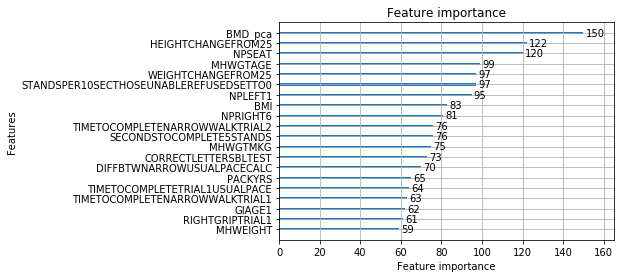

In [106]:
lgb.plot_importance(bst, max_num_features=20)

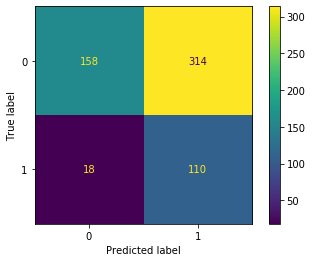

              precision    recall  f1-score   support

           0       0.90      0.33      0.49       472
           1       0.26      0.86      0.40       128

    accuracy                           0.45       600
   macro avg       0.58      0.60      0.44       600
weighted avg       0.76      0.45      0.47       600



In [107]:
thresh = optimizedf1(y_validation,bst.predict(X_validation))
makeConfusionMatrixandScore(bst,y_validation,X_validation, thresh = thresh)

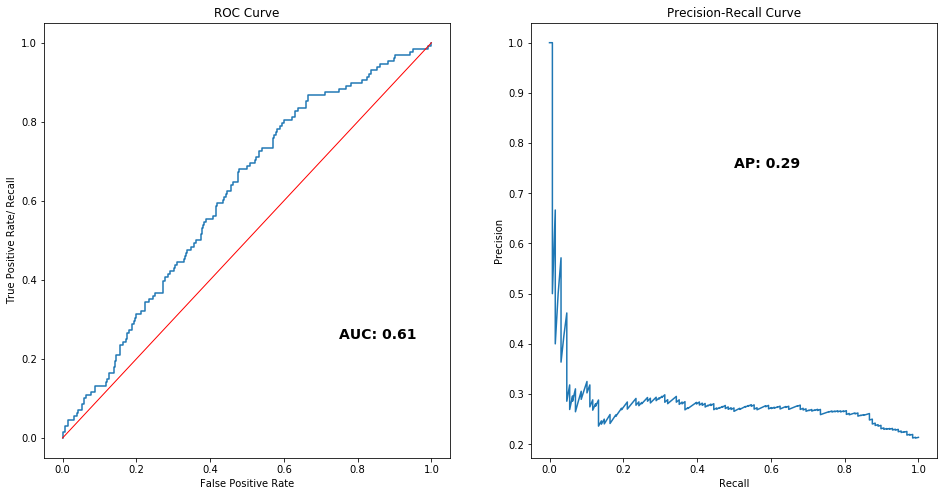

In [108]:
plot_roc_and_prc(y_validation,bst.predict(X_validation))

### <a name="eda_bor"></a> Applying Boruta Method

In [110]:
from sklearn.utils import check_random_state

class BorutaPyForLGB(BorutaPy):
    def __init__(self, estimator, n_estimators=1000, perc=100, alpha=0.05,
                 two_step=True, max_iter=100, random_state=None, verbose=0):
        super().__init__(estimator, n_estimators, perc, alpha,
                         two_step, max_iter, random_state, verbose)
        self._is_lightgbm = 'lightgbm' in str(type(self.estimator))
        
    def _fit(self, X, y):
        # check input params
        self._check_params(X, y)

        if not isinstance(X, np.ndarray):
            X = self._validate_pandas_input(X) 
        if not isinstance(y, np.ndarray):
            y = self._validate_pandas_input(y)

        self.random_state = check_random_state(self.random_state)
        # setup variables for Boruta
        n_sample, n_feat = X.shape
        _iter = 1
        # holds the decision about each feature:
        # 0  - default state = tentative in original code
        # 1  - accepted in original code
        # -1 - rejected in original code
        dec_reg = np.zeros(n_feat, dtype=np.int)
        # counts how many times a given feature was more important than
        # the best of the shadow features
        hit_reg = np.zeros(n_feat, dtype=np.int)
        # these record the history of the iterations
        imp_history = np.zeros(n_feat, dtype=np.float)
        sha_max_history = []

        # set n_estimators
        if self.n_estimators != 'auto':
            self.estimator.set_params(n_estimators=self.n_estimators)

        # main feature selection loop
        while np.any(dec_reg == 0) and _iter < self.max_iter:
            # find optimal number of trees and depth
            if self.n_estimators == 'auto':
                # number of features that aren't rejected
                not_rejected = np.where(dec_reg >= 0)[0].shape[0]
                n_tree = self._get_tree_num(not_rejected)
                self.estimator.set_params(n_estimators=n_tree)

            # make sure we start with a new tree in each iteration
            if self._is_lightgbm:
                self.estimator.set_params(random_state=self.random_state.randint(0, 10000))
            else:
                self.estimator.set_params(random_state=self.random_state)

            # add shadow attributes, shuffle them and train estimator, get imps
            cur_imp = self._add_shadows_get_imps(X, y, dec_reg)

            # get the threshold of shadow importances we will use for rejection
            imp_sha_max = np.percentile(cur_imp[1], self.perc)

            # record importance history
            sha_max_history.append(imp_sha_max)
            imp_history = np.vstack((imp_history, cur_imp[0]))

            # register which feature is more imp than the max of shadows
            hit_reg = self._assign_hits(hit_reg, cur_imp, imp_sha_max)

            # based on hit_reg we check if a feature is doing better than
            # expected by chance
            dec_reg = self._do_tests(dec_reg, hit_reg, _iter)

            # print out confirmed features
            if self.verbose > 0 and _iter < self.max_iter:
                self._print_results(dec_reg, _iter, 0)
            if _iter < self.max_iter:
                _iter += 1

        # we automatically apply R package's rough fix for tentative ones
        confirmed = np.where(dec_reg == 1)[0]
        tentative = np.where(dec_reg == 0)[0]
        # ignore the first row of zeros
        tentative_median = np.median(imp_history[1:, tentative], axis=0)
        # which tentative to keep
        tentative_confirmed = np.where(tentative_median
                                       > np.median(sha_max_history))[0]
        tentative = tentative[tentative_confirmed]

        # basic result variables
        self.n_features_ = confirmed.shape[0]
        self.support_ = np.zeros(n_feat, dtype=np.bool)
        self.support_[confirmed] = 1
        self.support_weak_ = np.zeros(n_feat, dtype=np.bool)
        self.support_weak_[tentative] = 1

        # ranking, confirmed variables are rank 1
        self.ranking_ = np.ones(n_feat, dtype=np.int)
        # tentative variables are rank 2
        self.ranking_[tentative] = 2
        # selected = confirmed and tentative
        selected = np.hstack((confirmed, tentative))
        # all rejected features are sorted by importance history
        not_selected = np.setdiff1d(np.arange(n_feat), selected)
        # large importance values should rank higher = lower ranks -> *(-1)
        imp_history_rejected = imp_history[1:, not_selected] * -1

        # update rank for not_selected features
        if not_selected.shape[0] > 0:
                # calculate ranks in each iteration, then median of ranks across feats
                iter_ranks = self._nanrankdata(imp_history_rejected, axis=1)
                rank_medians = np.nanmedian(iter_ranks, axis=0)
                ranks = self._nanrankdata(rank_medians, axis=0)

                # set smallest rank to 3 if there are tentative feats
                if tentative.shape[0] > 0:
                    ranks = ranks - np.min(ranks) + 3
                else:
                    # and 2 otherwise
                    ranks = ranks - np.min(ranks) + 2
                self.ranking_[not_selected] = ranks
        else:
            # all are selected, thus we set feature supports to True
            self.support_ = np.ones(n_feat, dtype=np.bool)

        self.importance_history_ = imp_history

        # notify user
        if self.verbose > 0:
            self._print_results(dec_reg, _iter, 1)
        return self

In [111]:
param = dict()
param["metric"] = 'auc'
param["objective"] = 'binary'
##for imbalanced data
param["scale_pos_weight"] = 2.33

In [112]:

lgbc = LGBMClassifier(num_boost_round=10)
feat_selector = BorutaPyForLGB(lgbc, n_estimators='auto', verbose=0, random_state=1, perc=55)
feat_selector.fit(X_train.values, y_train.values)

X_train.columns[feat_selector.support_]

[LightGBM] [Warning] num_iterations is set=10, num_boost_round=10 will be ignored. Current value: num_iterations=10


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will 

Index(['NPSEAT', 'NPLEFT1', 'MHWEIGHT', 'MHWGTAGE', 'MHHGTCM', 'MHWGTMKG',
       'SECONDSTOCOMPLETE5STANDS', 'TIMETOCOMPLETETRIAL1USUALPACE',
       'TIMETOCOMPLETENARROWWALKTRIAL1', 'TIMETOCOMPLETENARROWWALKTRIAL2',
       'TIMEFORNARROWWALKCALCVAR', 'DIFFBTWNARROWUSUALPACECALC',
       'STANDSPER10SECTHOSEUNABLEREFUSEDSETTO0',
       'HOWOLDWEREWHENSTOPPEDSMOKING', 'HOWMANYYEARSSMOKEDPIPECIGARS',
       'HOWMUCHPIPECIGARSDIDDOSMOKEWEEK', 'YRSSTOPPEDSMOKINGCIGARETTES',
       'PACKYRS', 'ADAYSDRANKPERWKMOYR', 'NUMBEROFDRINKSWKCALCVAR',
       'HMGCOAREDUCTASEINHIBITORSTATIN', 'TAKEASPIRINATLEAST3XWEEK',
       'RIGHTGRIPTRIAL1', 'LEFTGRIPTRIAL1', 'BMI', 'HEIGHTCHANGEFROM25',
       'WEIGHTCHANGEFROM25', 'GIAGE1', 'NoFracture', 'FractureAfter50',
       'GIERACE_1WHITE', 'BMD_pca'],
      dtype='object')

In [113]:
X_train = X_train.loc[:,feat_selector.support_]
X_validation = X_validation.loc[:,feat_selector.support_]

In [114]:
train_data = lgb.Dataset(X_train,label=y_train)

param = dict()
param["metric"] = 'auc'
param["objective"] = 'binary'
##for imbalanced data
param["scale_pos_weight"] = 2.33



bst = lgb.train(param, train_data)

[LightGBM] [Info] Number of positive: 1031, number of negative: 3764
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4309
[LightGBM] [Info] Number of data points in the train set: 4795, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215016 -> initscore=-1.294953
[LightGBM] [Info] Start training from score -1.294953


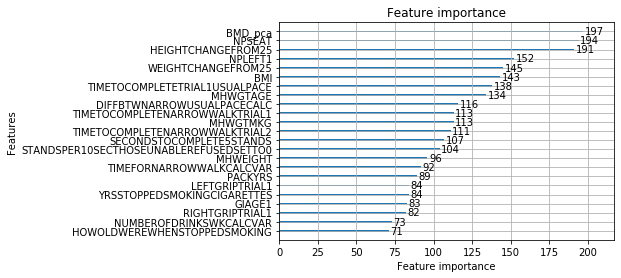

In [115]:
lgb.plot_importance(bst, max_num_features=23)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


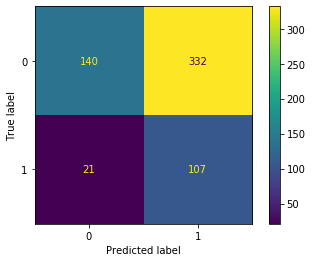

              precision    recall  f1-score   support

           0       0.87      0.30      0.44       472
           1       0.24      0.84      0.38       128

    accuracy                           0.41       600
   macro avg       0.56      0.57      0.41       600
weighted avg       0.74      0.41      0.43       600



In [116]:
thresh = optimizedf1(y_validation,bst.predict(X_validation))
makeConfusionMatrixandScore(bst,y_validation,X_validation, thresh = thresh)

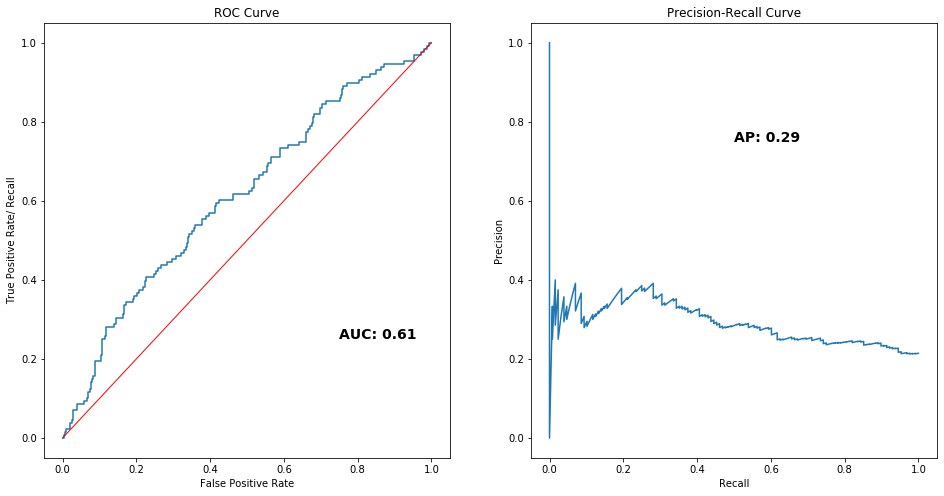

In [117]:
plot_roc_and_prc(y_validation,bst.predict(X_validation))

### <a name="eda_SMOTE"></a> Applying SMOTE Resampling
Because including an imbalanced parameter is not very effective at managing our imbalanced data, we will resample the data using SMOTE.

In [119]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train,y_train)

In [120]:
train_data = lgb.Dataset(X_train_res,label=y_train_res)

param = dict()
param["metric"] = 'auc'
param["objective"] = 'binary'
##for imbalanced data

bst = lgb.train(param, train_data)

[LightGBM] [Info] Number of positive: 3764, number of negative: 3764
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7398
[LightGBM] [Info] Number of data points in the train set: 7528, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


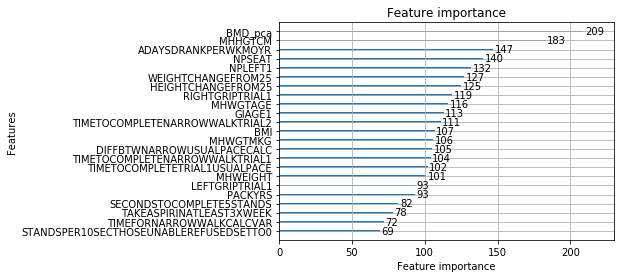

In [121]:
lgb.plot_importance(bst, max_num_features=23)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


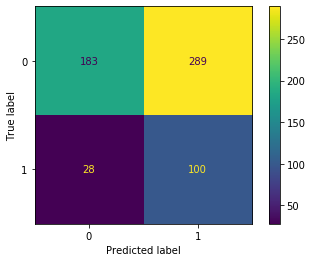

              precision    recall  f1-score   support

           0       0.87      0.39      0.54       472
           1       0.26      0.78      0.39       128

    accuracy                           0.47       600
   macro avg       0.56      0.58      0.46       600
weighted avg       0.74      0.47      0.50       600



In [122]:
thresh = optimizedf1(y_validation,bst.predict(X_validation))
makeConfusionMatrixandScore(bst,y_validation,X_validation, thresh = thresh)

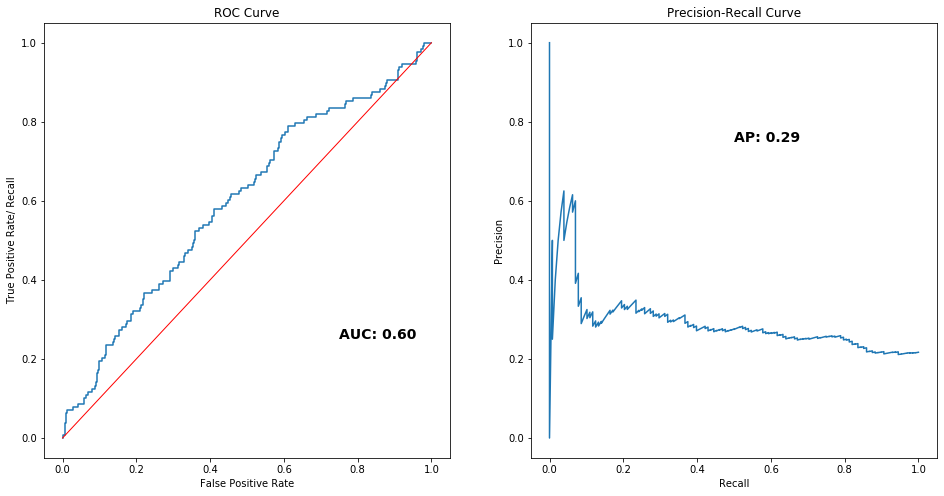

In [123]:
plot_roc_and_prc(y_validation,bst.predict(X_validation))

SMOTE does not appear to improve the f1 score or recall

### Save Feature Selection

In [125]:
file_path = "/dsa/groups/casestudy2023su/team03/merged_data/LGBM/"

X_train.to_csv((file_path+"X_train.csv"),index=False)
X_validation.to_csv((file_path+"X_validation.csv"),index=False)
os.chmod((file_path+"X_train.csv"),0o777)
os.chmod((file_path+"X_validation.csv"),0o777)

In [126]:
import joblib
joblib.dump(pca,file_path+r"pca.pkl")
joblib.dump(scale,file_path+r"scale.pkl")
feature_selection = X_train.columns
joblib.dump(feature_selection,file_path+r"features.pkl")
joblib.dump(makeConfusionMatrixandScore,"/dsa/groups/casestudy2023su/team03/joshlib/makeConfusionMatrixandScore.pkl")

os.chmod((file_path+"pca.pkl"),0o777)
os.chmod((file_path+"scale.pkl"),0o777)
os.chmod((file_path+"features.pkl"),0o777)